In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses
from keras.applications import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input
from keras.preprocessing import image_dataset_from_directory, image
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2025-07-15 15:54:26.733780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("obulisainaren/multi-cancer")

print("Path to dataset files:", path)


Path to dataset files: /Users/Coding/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3


In [5]:
BATCH = 16
SIZE = (224,224)

directory = '/Users/Coding/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3/Multi Cancer/Multi Cancer'

def data_loading(types, subset):
    print(f"{types}'s {subset} dataset")
    directory1 = directory + "/" + types
    dataset = image_dataset_from_directory(
        directory1,
        labels = "inferred",
        label_mode = "categorical",
        validation_split = 0.2,
        subset = subset,
        shuffle = True,
        seed = 123,
        batch_size = BATCH,
        image_size = SIZE,
    )
    return dataset

brain_dataset_train = data_loading("Brain Cancer", "training")
brain_dataset_val = data_loading("Brain Cancer", "validation")
breast_dataset_train = data_loading("Breast Cancer", "training")
breast_dataset_val = data_loading("Breast Cancer", "validation")
cervical_dataset_train = data_loading("Cervical Cancer", "training")
cervical_dataset_val = data_loading("Cervical Cancer", "validation")
kidney_dataset_train = data_loading("Kidney Cancer", "training")
kidney_dataset_val = data_loading("Kidney Cancer", "validation")
colon_dataset_train = data_loading("Lung and Colon Cancer", "training")
colon_dataset_val = data_loading("Lung and Colon Cancer", "validation")
lymphoma_dataset_train = data_loading("Lymphoma", "training")
lymphoma_dataset_val = data_loading("Lymphoma", "validation")
oral_dataset_train = data_loading("Oral Cancer", "training")
oral_dataset_val = data_loading("Oral Cancer", "validation")

Brain Cancer's training dataset
Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Brain Cancer's validation dataset
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Breast Cancer's training dataset
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Breast Cancer's validation dataset
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Cervical Cancer's training dataset
Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Cervical Cancer's validation dataset
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.
Kidney Cancer's training dataset
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Kidney Cancer's validation dataset
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Lung and Colon Cancer's training dataset
Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Lung and Colon Ca

In [7]:
import tensorflow as tf
import os

def filtered_data_loading(exclude_type, subset):
    print(f"Loading multi-cancer dataset excluding {exclude_type}")
    full_dir = "/Users/Coding/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3/Multi Cancer/Multi Cancer"
    class_dirs = [
        d for d in os.listdir(full_dir)
        if os.path.isdir(os.path.join(full_dir, d)) and d != exclude_type
    ]
    temp_dir = "new_models/temp"

    # Create symlinked structure
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
        for d in class_dirs:
            os.symlink(os.path.join(full_dir, d), os.path.join(temp_dir, d))

    return tf.keras.preprocessing.image_dataset_from_directory(
        temp_dir,
        labels="inferred",
        label_mode="categorical",
        validation_split=0.2,
        subset=subset,
        seed=123,
        shuffle=True,
        batch_size=16,
        image_size=(224, 224)
    )

main_dataset_train = filtered_data_loading("ALL", "training")
main_dataset_val = filtered_data_loading("ALL", "validation")

Loading multi-cancer dataset excluding ALL
Found 110002 files belonging to 7 classes.
Using 88002 files for training.
Loading multi-cancer dataset excluding ALL
Found 110002 files belonging to 7 classes.
Using 22000 files for validation.


In [8]:
main_dataset_train.class_names

['Brain Cancer',
 'Breast Cancer',
 'Cervical Cancer',
 'Kidney Cancer',
 'Lung and Colon Cancer',
 'Lymphoma',
 'Oral Cancer']

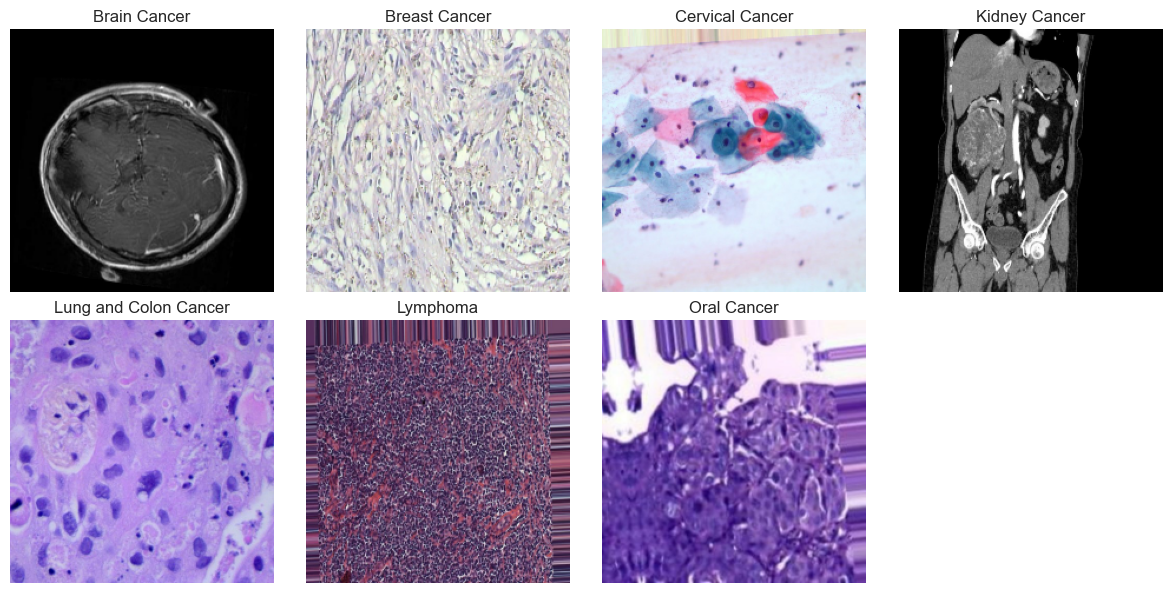

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import math

class_names = main_dataset_train.class_names

rep_images = {cls: None for cls in class_names}

# iterate until you’ve seen one image of each class
for batch in main_dataset_train.unbatch().batch(1):
    img, label = batch
    idx = np.argmax(label.numpy())
    cls = class_names[idx]
    if rep_images[cls] is None:
        rep_images[cls] = img[0].numpy().astype("uint8")
    if all(v is not None for v in rep_images.values()):
        break

n = len(class_names)
cols = 4
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 3, rows * 3))
for i, cls in enumerate(class_names):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(rep_images[cls])
    ax.set_title(cls)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [11]:
import os

root_path = "/Users/Coding/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3/Multi Cancer/Multi Cancer"

def list_subtypes(cancer_type):
    path = os.path.join(root_path, cancer_type)
    if os.path.exists(path):
        subtypes = sorted(os.listdir(path))
        print(f"{cancer_type} subtypes: {subtypes}")
    else:
        print(f"{cancer_type} folder not found.")

# Example usage
list_subtypes("Brain Cancer")
list_subtypes("Breast Cancer")
list_subtypes("Cervical Cancer")
list_subtypes("Lung and Colon Cancer")
list_subtypes("Lymphoma")
list_subtypes("Kidney Cancer")
list_subtypes("Oral Cancer")

Brain Cancer subtypes: ['brain_glioma', 'brain_menin', 'brain_tumor']
Breast Cancer subtypes: ['breast_benign', 'breast_malignant']
Cervical Cancer subtypes: ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Lung and Colon Cancer subtypes: ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Lymphoma subtypes: ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Kidney Cancer subtypes: ['kidney_normal', 'kidney_tumor']
Oral Cancer subtypes: ['oral_normal', 'oral_scc']


In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_sample_images(cancer_type, n=3):
    path = os.path.join(root_path, cancer_type)
    subtypes = os.listdir(path)

    for subtype in subtypes:
        subtype_path = os.path.join(path, subtype)
        images = os.listdir(subtype_path)[:n]
        print(f"{subtype} sample images:")
        plt.figure(figsize=(10, 2))
        for i, img_name in enumerate(images):
            img_path = os.path.join(subtype_path, img_name)
            img = mpimg.imread(img_path)
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.title(subtype)
            plt.axis("off")
        plt.show()

breast_benign sample images:


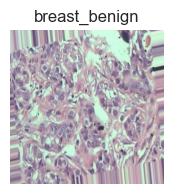

breast_malignant sample images:


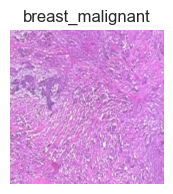

In [15]:
import os
root_path = "/Users/Coding/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3/Multi Cancer/Multi Cancer"  # Define if not already
show_sample_images("Breast Cancer", n=1)

In [25]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_model(num_classes):
    # Load the pre-trained MobileNetV3 model
    pre_model = MobileNetV3Large(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers to use transfer learning
    pre_model.trainable = False

    # Add custom classification layers
    x = pre_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = models.Model(inputs=pre_model.input, outputs=output_layer)

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    return model

In [37]:
def train_model(train_data, val_data, num_classes, model_name):
    model = create_model(num_classes)
    history = model.fit(train_data, validation_data=val_data, epochs=10)  # Store history
    model.save(f"{model_name}_model.keras")
    return history, model  # Return both history and model

In [27]:
def train_model_oral(train_data, val_data, num_classes, model_name):
    model = create_model(num_classes)
    history = model.fit(train_data, validation_data=val_data, epochs=15)  # Store history
    model.save(f"{model_name}_model.h5")
    return history, model  # Return both history and model

In [28]:
import matplotlib.pyplot as plt

def plot_class_distribution(dataset, title):
    class_counts = {}
    class_names = dataset.class_names  # Get class labels
    for images, labels in dataset:
        for label in labels.numpy():
            class_index = label.argmax()
            class_counts[class_names[class_index]] = class_counts.get(class_names[class_index], 0) + 1

    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


In [29]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Model Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Model Loss")

    plt.show()


In [30]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataset, class_names):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [31]:
import random

def plot_sample_predictions(model, dataset, class_names):
    images, labels = next(iter(dataset))
    predictions = model.predict(images)

    num_images = images.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(min(9, num_images)):  # Show up to 9 images, but not more than available
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = class_names[np.argmax(predictions[i])]
        true_label = class_names[np.argmax(labels[i].numpy())]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color="green" if pred_label == true_label else "red")
        plt.axis("off")
plt.show()


In [32]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def generate_gradcam_heatmap(model, image, class_index, last_conv_layer_name="conv_1"):

    # Create a model that outputs the last conv layer and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    # Gradient of loss w.r.t. conv layer output
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)  # avoid div by zero
    heatmap = heatmap.numpy()

    # Resize heatmap to match input image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Prepare original image for overlay
    img_display = image[0].numpy()
    if np.max(img_display) <= 1.0:
        img_display = np.uint8(255 * img_display)
    else:
        img_display = np.uint8(img_display)

    # If grayscale, convert to 3 channels
    if img_display.shape[-1] == 1:
        img_display = np.repeat(img_display, 3, axis=-1)

    # Convert to BGR for OpenCV overlay
    img_display_bgr = cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR)

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(img_display_bgr, 0.6, heatmap_colored, 0.4, 0)

    # Display
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img_display_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap_resized, cmap='jet')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Superimposed")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Training

In [33]:
brain_dataset_train = data_loading("Brain Cancer", "training")
brain_dataset_val = data_loading("Brain Cancer", "validation")

num_classes_brain = 3
history, model = train_model(brain_dataset_train, brain_dataset_val, num_classes_brain, "brain_cancer")

# Now you can evaluate the model
loss, accuracy = model.evaluate(brain_dataset_val)
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

Brain Cancer's training dataset
Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Brain Cancer's validation dataset
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
12683000/12683000 [==============================] - 1s 0us/step
Epoch 1/10
750/750 [==============================] - 336s 440ms/step - loss: 0.1895 - accuracy: 0.9306 - val_loss: 0.0788 - val_accuracy: 0.9727
Epoch 2/10
750/750 [==============================] - 322s 430ms/step - loss: 0.0642 - accuracy: 0.9778 - val_loss: 0.0834 - val_accuracy: 0.9717
Epoch 3/10
750/750 [==============================] - 311s 414ms/step - loss: 0.0274 - accuracy: 0.9914 - val_loss: 0.0326 - val_accuracy: 0.9887
Epoch 4/10
750/750 [==============================] - 281s 375ms/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.0579 - val_accuracy: 0.9817
Epoch 5/10
750/750 [==============================] - 282s 376ms/step - loss: 0.0188 - accuracy: 0.9935 - val_loss: 0.0247 - val_accurac

/Users/coding/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/188 [==============================] - 56s 296ms/step - loss: 0.0152 - accuracy: 0.9937
Evaluation Results - Loss: 0.015152860432863235, Accuracy: 0.9936666488647461


In [35]:
model.save("new_models/models/brain_cancer_model.keras")

In [36]:
model = tf.keras.models.load_model("new_models/models/brain_cancer_model.keras")

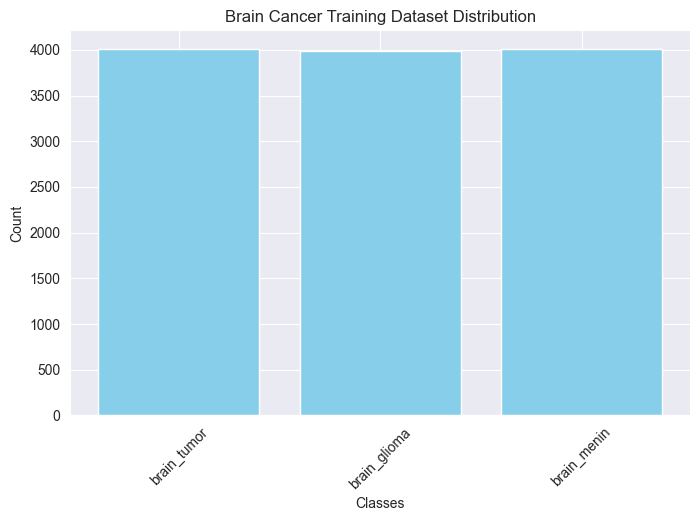

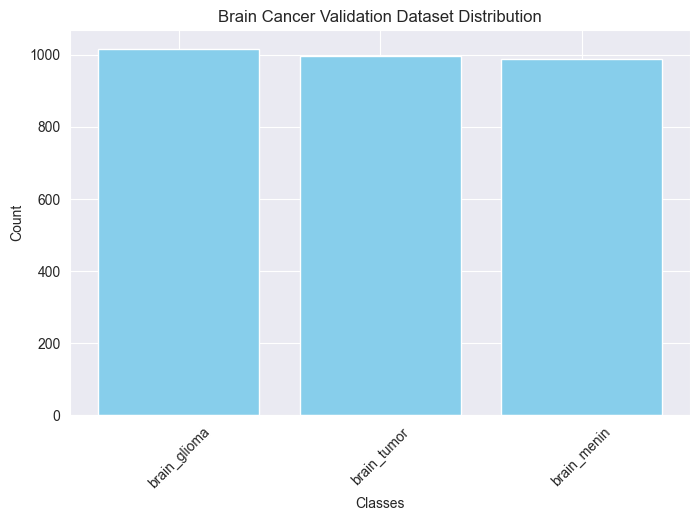

In [38]:
plot_class_distribution(brain_dataset_train, "Brain Cancer Training Dataset Distribution")
plot_class_distribution(brain_dataset_val, "Brain Cancer Validation Dataset Distribution")

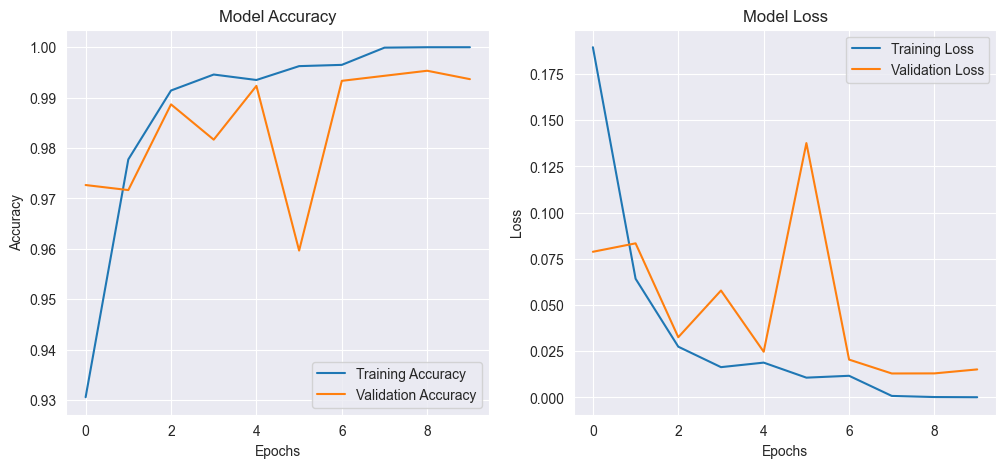

In [39]:
plot_training_history(history)

1/1 [==============================] - 0s 195ms/step


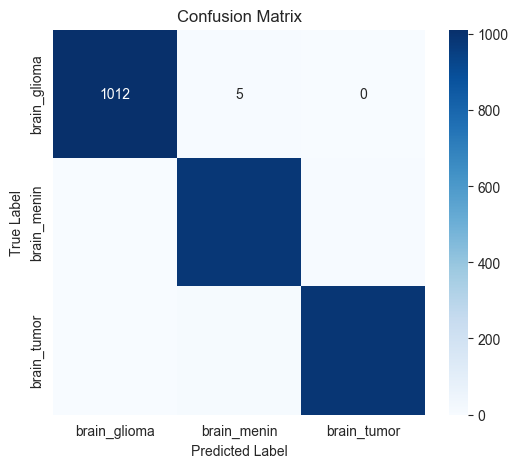

In [40]:
plot_confusion_matrix(model, brain_dataset_val, brain_dataset_val.class_names)

1/1 [==============================] - 0s 453ms/step


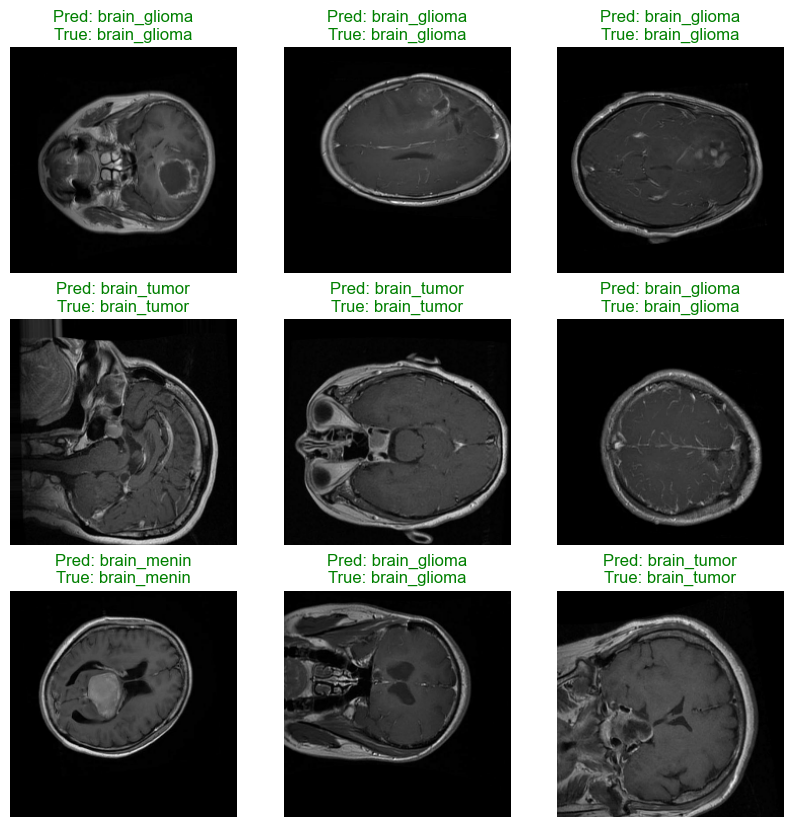

In [41]:
plot_sample_predictions(model, brain_dataset_val, brain_dataset_val.class_names)

In [42]:
# Get a batch from your validation dataset
image_batch, label_batch = next(iter(brain_dataset_val))
image = image_batch[0]
label = label_batch[0]

# Add batch dimension
image_input = tf.expand_dims(image, axis=0)

# Predict the class
preds = model.predict(image_input)
predicted_class = tf.argmax(preds[0])

# Run Grad-CAM for the predicted class
generate_gradcam_heatmap(model, image_input, class_index=predicted_class)

1/1 [==============================] - 0s 40ms/step


ValueError: No such layer: conv_1. Existing layers are: ['input_1', 'rescaling', 'Conv', 'Conv/BatchNorm', 'tf.__operators__.add', 're_lu', 'tf.math.multiply', 'multiply', 'expanded_conv/depthwise', 'expanded_conv/depthwise/BatchNorm', 're_lu_1', 'expanded_conv/project', 'expanded_conv/project/BatchNorm', 'expanded_conv/Add', 'expanded_conv_1/expand', 'expanded_conv_1/expand/BatchNorm', 're_lu_2', 'expanded_conv_1/depthwise/pad', 'expanded_conv_1/depthwise', 'expanded_conv_1/depthwise/BatchNorm', 're_lu_3', 'expanded_conv_1/project', 'expanded_conv_1/project/BatchNorm', 'expanded_conv_2/expand', 'expanded_conv_2/expand/BatchNorm', 're_lu_4', 'expanded_conv_2/depthwise', 'expanded_conv_2/depthwise/BatchNorm', 're_lu_5', 'expanded_conv_2/project', 'expanded_conv_2/project/BatchNorm', 'expanded_conv_2/Add', 'expanded_conv_3/expand', 'expanded_conv_3/expand/BatchNorm', 're_lu_6', 'expanded_conv_3/depthwise/pad', 'expanded_conv_3/depthwise', 'expanded_conv_3/depthwise/BatchNorm', 're_lu_7', 'expanded_conv_3/squeeze_excite/AvgPool', 'expanded_conv_3/squeeze_excite/Conv', 'expanded_conv_3/squeeze_excite/Relu', 'expanded_conv_3/squeeze_excite/Conv_1', 'tf.__operators__.add_1', 're_lu_8', 'tf.math.multiply_1', 'expanded_conv_3/squeeze_excite/Mul', 'expanded_conv_3/project', 'expanded_conv_3/project/BatchNorm', 'expanded_conv_4/expand', 'expanded_conv_4/expand/BatchNorm', 're_lu_9', 'expanded_conv_4/depthwise', 'expanded_conv_4/depthwise/BatchNorm', 're_lu_10', 'expanded_conv_4/squeeze_excite/AvgPool', 'expanded_conv_4/squeeze_excite/Conv', 'expanded_conv_4/squeeze_excite/Relu', 'expanded_conv_4/squeeze_excite/Conv_1', 'tf.__operators__.add_2', 're_lu_11', 'tf.math.multiply_2', 'expanded_conv_4/squeeze_excite/Mul', 'expanded_conv_4/project', 'expanded_conv_4/project/BatchNorm', 'expanded_conv_4/Add', 'expanded_conv_5/expand', 'expanded_conv_5/expand/BatchNorm', 're_lu_12', 'expanded_conv_5/depthwise', 'expanded_conv_5/depthwise/BatchNorm', 're_lu_13', 'expanded_conv_5/squeeze_excite/AvgPool', 'expanded_conv_5/squeeze_excite/Conv', 'expanded_conv_5/squeeze_excite/Relu', 'expanded_conv_5/squeeze_excite/Conv_1', 'tf.__operators__.add_3', 're_lu_14', 'tf.math.multiply_3', 'expanded_conv_5/squeeze_excite/Mul', 'expanded_conv_5/project', 'expanded_conv_5/project/BatchNorm', 'expanded_conv_5/Add', 'expanded_conv_6/expand', 'expanded_conv_6/expand/BatchNorm', 'tf.__operators__.add_4', 're_lu_15', 'tf.math.multiply_4', 'multiply_1', 'expanded_conv_6/depthwise/pad', 'expanded_conv_6/depthwise', 'expanded_conv_6/depthwise/BatchNorm', 'tf.__operators__.add_5', 're_lu_16', 'tf.math.multiply_5', 'multiply_2', 'expanded_conv_6/project', 'expanded_conv_6/project/BatchNorm', 'expanded_conv_7/expand', 'expanded_conv_7/expand/BatchNorm', 'tf.__operators__.add_6', 're_lu_17', 'tf.math.multiply_6', 'multiply_3', 'expanded_conv_7/depthwise', 'expanded_conv_7/depthwise/BatchNorm', 'tf.__operators__.add_7', 're_lu_18', 'tf.math.multiply_7', 'multiply_4', 'expanded_conv_7/project', 'expanded_conv_7/project/BatchNorm', 'expanded_conv_7/Add', 'expanded_conv_8/expand', 'expanded_conv_8/expand/BatchNorm', 'tf.__operators__.add_8', 're_lu_19', 'tf.math.multiply_8', 'multiply_5', 'expanded_conv_8/depthwise', 'expanded_conv_8/depthwise/BatchNorm', 'tf.__operators__.add_9', 're_lu_20', 'tf.math.multiply_9', 'multiply_6', 'expanded_conv_8/project', 'expanded_conv_8/project/BatchNorm', 'expanded_conv_8/Add', 'expanded_conv_9/expand', 'expanded_conv_9/expand/BatchNorm', 'tf.__operators__.add_10', 're_lu_21', 'tf.math.multiply_10', 'multiply_7', 'expanded_conv_9/depthwise', 'expanded_conv_9/depthwise/BatchNorm', 'tf.__operators__.add_11', 're_lu_22', 'tf.math.multiply_11', 'multiply_8', 'expanded_conv_9/project', 'expanded_conv_9/project/BatchNorm', 'expanded_conv_9/Add', 'expanded_conv_10/expand', 'expanded_conv_10/expand/BatchNorm', 'tf.__operators__.add_12', 're_lu_23', 'tf.math.multiply_12', 'multiply_9', 'expanded_conv_10/depthwise', 'expanded_conv_10/depthwise/BatchNorm', 'tf.__operators__.add_13', 're_lu_24', 'tf.math.multiply_13', 'multiply_10', 'expanded_conv_10/squeeze_excite/AvgPool', 'expanded_conv_10/squeeze_excite/Conv', 'expanded_conv_10/squeeze_excite/Relu', 'expanded_conv_10/squeeze_excite/Conv_1', 'tf.__operators__.add_14', 're_lu_25', 'tf.math.multiply_14', 'expanded_conv_10/squeeze_excite/Mul', 'expanded_conv_10/project', 'expanded_conv_10/project/BatchNorm', 'expanded_conv_11/expand', 'expanded_conv_11/expand/BatchNorm', 'tf.__operators__.add_15', 're_lu_26', 'tf.math.multiply_15', 'multiply_11', 'expanded_conv_11/depthwise', 'expanded_conv_11/depthwise/BatchNorm', 'tf.__operators__.add_16', 're_lu_27', 'tf.math.multiply_16', 'multiply_12', 'expanded_conv_11/squeeze_excite/AvgPool', 'expanded_conv_11/squeeze_excite/Conv', 'expanded_conv_11/squeeze_excite/Relu', 'expanded_conv_11/squeeze_excite/Conv_1', 'tf.__operators__.add_17', 're_lu_28', 'tf.math.multiply_17', 'expanded_conv_11/squeeze_excite/Mul', 'expanded_conv_11/project', 'expanded_conv_11/project/BatchNorm', 'expanded_conv_11/Add', 'expanded_conv_12/expand', 'expanded_conv_12/expand/BatchNorm', 'tf.__operators__.add_18', 're_lu_29', 'tf.math.multiply_18', 'multiply_13', 'expanded_conv_12/depthwise/pad', 'expanded_conv_12/depthwise', 'expanded_conv_12/depthwise/BatchNorm', 'tf.__operators__.add_19', 're_lu_30', 'tf.math.multiply_19', 'multiply_14', 'expanded_conv_12/squeeze_excite/AvgPool', 'expanded_conv_12/squeeze_excite/Conv', 'expanded_conv_12/squeeze_excite/Relu', 'expanded_conv_12/squeeze_excite/Conv_1', 'tf.__operators__.add_20', 're_lu_31', 'tf.math.multiply_20', 'expanded_conv_12/squeeze_excite/Mul', 'expanded_conv_12/project', 'expanded_conv_12/project/BatchNorm', 'expanded_conv_13/expand', 'expanded_conv_13/expand/BatchNorm', 'tf.__operators__.add_21', 're_lu_32', 'tf.math.multiply_21', 'multiply_15', 'expanded_conv_13/depthwise', 'expanded_conv_13/depthwise/BatchNorm', 'tf.__operators__.add_22', 're_lu_33', 'tf.math.multiply_22', 'multiply_16', 'expanded_conv_13/squeeze_excite/AvgPool', 'expanded_conv_13/squeeze_excite/Conv', 'expanded_conv_13/squeeze_excite/Relu', 'expanded_conv_13/squeeze_excite/Conv_1', 'tf.__operators__.add_23', 're_lu_34', 'tf.math.multiply_23', 'expanded_conv_13/squeeze_excite/Mul', 'expanded_conv_13/project', 'expanded_conv_13/project/BatchNorm', 'expanded_conv_13/Add', 'expanded_conv_14/expand', 'expanded_conv_14/expand/BatchNorm', 'tf.__operators__.add_24', 're_lu_35', 'tf.math.multiply_24', 'multiply_17', 'expanded_conv_14/depthwise', 'expanded_conv_14/depthwise/BatchNorm', 'tf.__operators__.add_25', 're_lu_36', 'tf.math.multiply_25', 'multiply_18', 'expanded_conv_14/squeeze_excite/AvgPool', 'expanded_conv_14/squeeze_excite/Conv', 'expanded_conv_14/squeeze_excite/Relu', 'expanded_conv_14/squeeze_excite/Conv_1', 'tf.__operators__.add_26', 're_lu_37', 'tf.math.multiply_26', 'expanded_conv_14/squeeze_excite/Mul', 'expanded_conv_14/project', 'expanded_conv_14/project/BatchNorm', 'expanded_conv_14/Add', 'Conv_1', 'Conv_1/BatchNorm', 'tf.__operators__.add_27', 're_lu_38', 'tf.math.multiply_27', 'multiply_19', 'global_average_pooling2d', 'dense', 'dense_1', 'dense_2', 'dense_3'].

In [ ]:
import matplotlib.pyplot as plt

cancer_types = ['Brain', 'Breast', 'Cervical', 'Kidney', 'Colon', 'Lymphoma', 'Oral']
accuracies = [ 0.9937, 0.9980,  0.9994, 0.9994, 0.9986, 0.9879, 0.9605]

plt.figure(figsize=(10, 6))
plt.bar(cancer_types, accuracies, color='teal')
plt.ylim(0.8, 1.05)
plt.title("Validation Accuracy per Cancer Type")
plt.ylabel("Accuracy")
plt.xlabel("Cancer Type")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    